# 2. Amazon
## STEP 1 : 시계열 데이터 준비

In [8]:
from google.colab import files
myfile = files.upload()

Saving AMZN.csv to AMZN.csv


In [36]:
import io
import sklearn
import statsmodels
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 
import warnings
warnings.filterwarnings('ignore') 

In [13]:
#pd.read_csv로 csv파일 불러오기
data = pd.read_csv(io.BytesIO(myfile['AMZN.csv']), index_col='Date', parse_dates=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,170.438004,171.399994,166.349503,167.522003,167.522003,70726000
2022-01-05,166.882996,167.126495,164.356995,164.356995,164.356995,64302000
2022-01-06,163.450500,164.800003,161.936996,163.253998,163.253998,51958000
2022-01-07,163.839005,165.243500,162.031006,162.554001,162.554001,46606000
2022-01-10,160.585495,161.661499,156.304504,161.485992,161.485992,87798000


In [14]:
ts = data['Close']
ts.head()

Date
2022-01-04    167.522003
2022-01-05    164.356995
2022-01-06    163.253998
2022-01-07    162.554001
2022-01-10    161.485992
Name: Close, dtype: float64

#### 클라우드 주피터에 csv 파일 업로드가 안돼서, colab에서 진행했다.    

REF)     
https://growthj.link/python-%EA%B5%AC%EA%B8%80-colab%EC%9C%BC%EB%A1%9C-pd-read-csv-%ED%99%9C%EC%9A%A9%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95/  colab으로 csv 파일 업로드   
https://blog.naver.com/nabilera1/222587254561 colab 마크다운 단축키

# STEP 2 : 각종 전처리 수행


In [16]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

#### 결측치는 없다. 

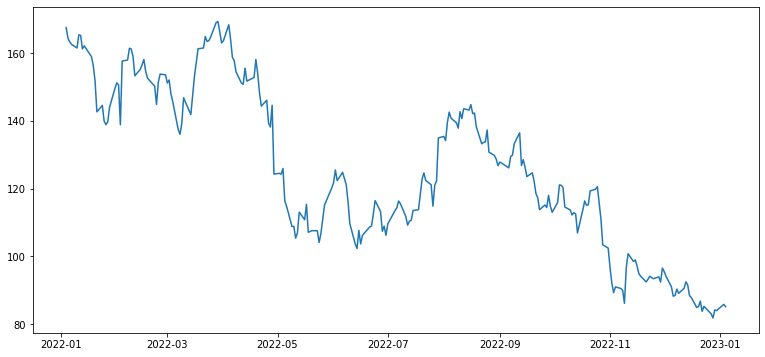

In [18]:
plt.plot(ts)

#### 주가가 1년 새에 반토막이 됐다. 

In [19]:
# 로그 변환
ts_log = np.log(ts)
ts_log

Date
2022-01-04    5.121115
2022-01-05    5.102041
2022-01-06    5.095307
2022-01-07    5.091010
2022-01-10    5.084418
                ...   
2022-12-28    4.404522
2022-12-29    4.432957
2022-12-30    4.430817
2023-01-03    4.452252
2023-01-04    4.444297
Name: Close, Length: 252, dtype: float64

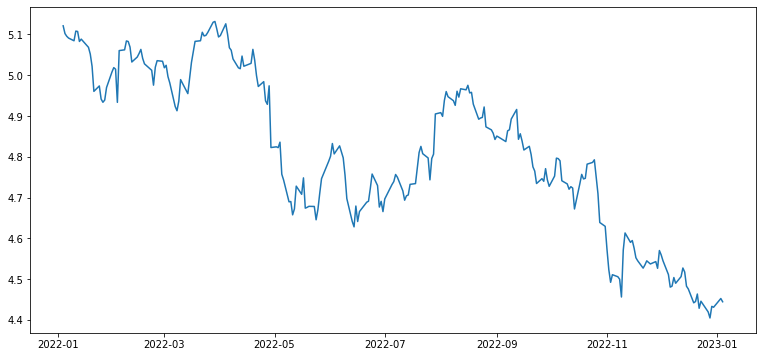

In [20]:
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

In [21]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('주식왕이될 준비 1단계 완료!')

주식왕이될 준비 1단계 완료!


In [22]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('주식왕이될 준비 2단계 완료!')

주식왕이될 준비 2단계 완료!


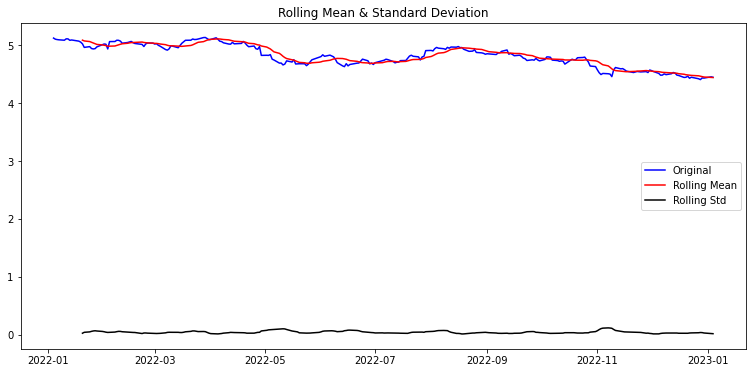

Results of Dickey-Fuller Test:
Test Statistic                  -1.061477
p-value                          0.730187
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


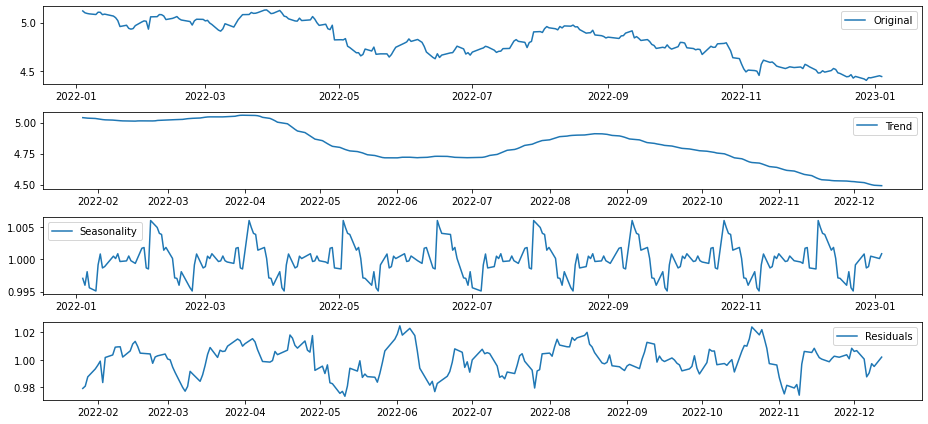

In [25]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


#### p-value 값이 0.7로 꽤 높다. 귀무가설이 맞는 쪽에 가깝다. 

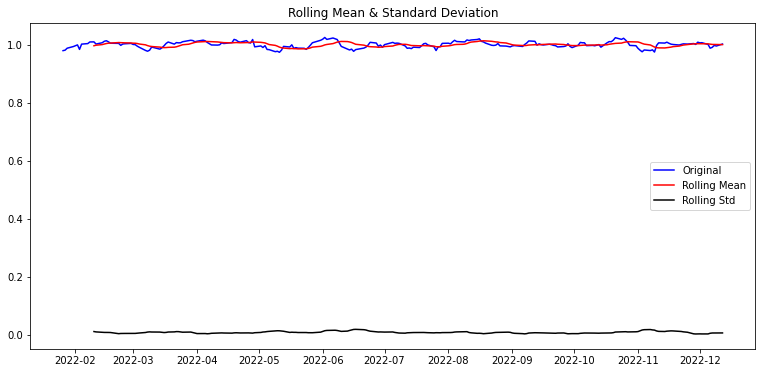

In [26]:
plot_rolling_statistics(residual)

In [27]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.427553
p-value                          0.000003
#Lags Used                       2.000000
Number of Observations Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


#### Residual의 p-value가 0.000003으로 꽤 작다   
    
    

## STEP 4 : 학습, 테스트 데이터셋 생성

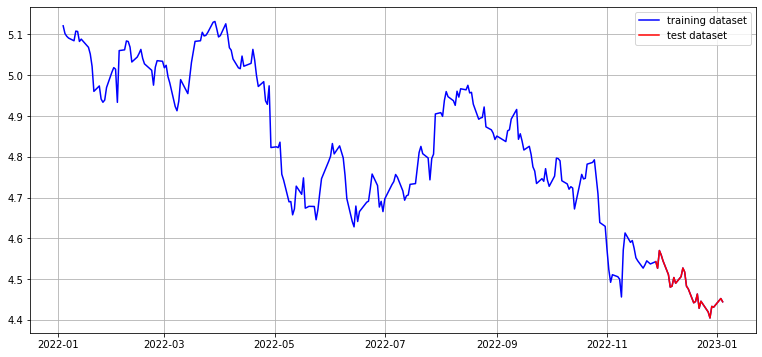

In [28]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure()
plt.grid(True)
plt.plot(ts_log, c='b', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='r', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

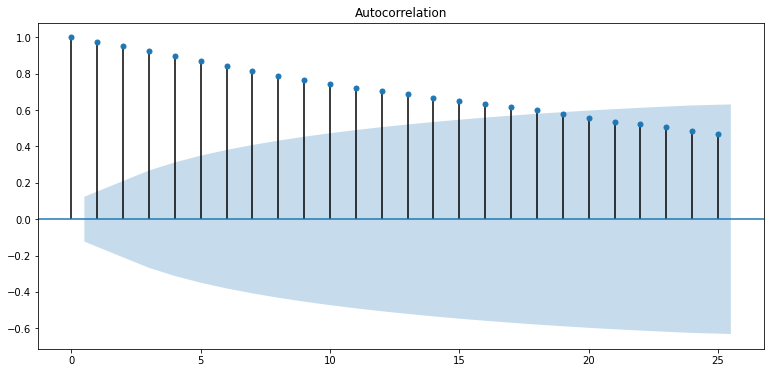

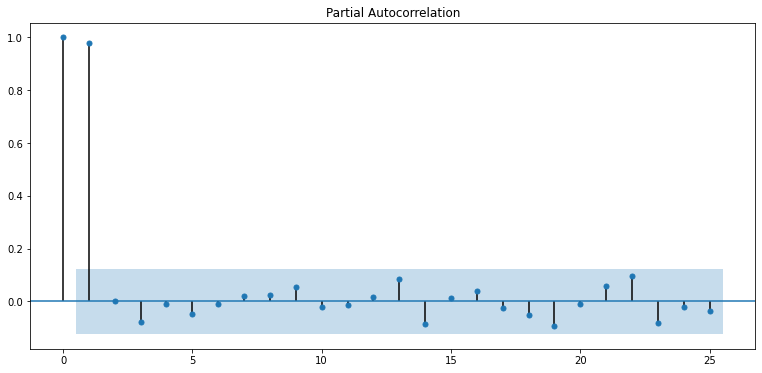

In [33]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   
plot_pacf(ts_log) 
plt.show()

#### ACF는 완만하게 감소하기 때문에 q=0이 적합하다. 
#### PACF는 lag 1이 유의미하다. p=1이 적합하다. 
#### colab에서는 오히려 AttributeError: 'Line2D' object has no property 'auto_ylims' 이런 에러가 나와 auto_ylims= True를 없애주었다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.571629e+01
p-value                        1.340598e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


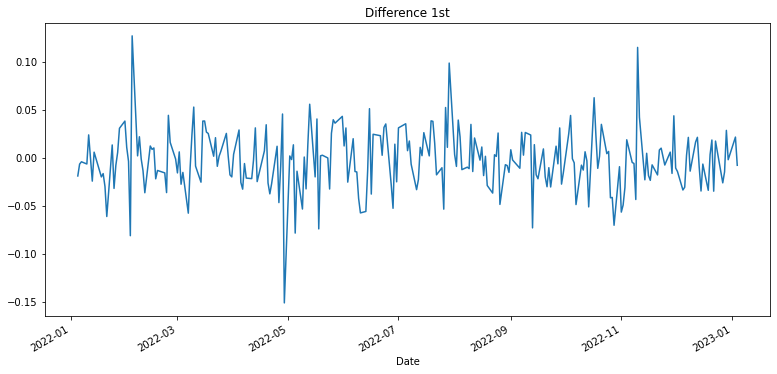

In [34]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#### 1차 차분으로 p-value가 많이 낮아졌다. 

Results of Dickey-Fuller Test:
Test Statistic                -8.553420e+00
p-value                        9.093374e-14
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


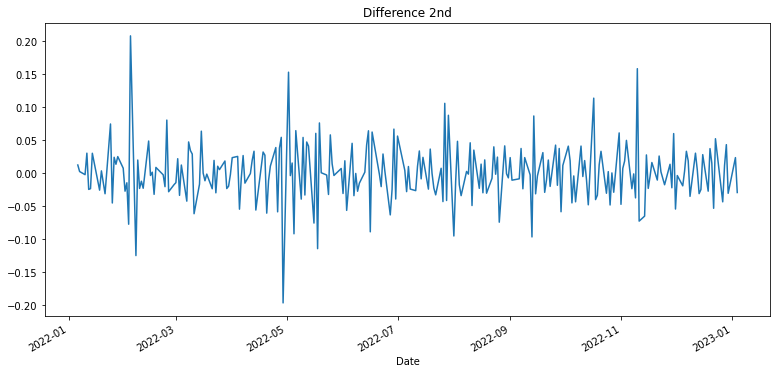

In [35]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

#### 2차 차분보다 1차 차분에서 p-value 값이 낮다. d=1이 적합하다. 

## STEP 6 : ARIMA 모델 훈련과 테스트

In [42]:
from statsmodels.tsa.arima.model import ARIMA
model1 = ARIMA(train_data, order=(0,1,0))
model2 = ARIMA(train_data, order=(0,1,1))
model3 = ARIMA(train_data, order=(1,1,0))

res1 = model1.fit()
res2 = model2.fit()
res3 = model3.fit()

In [38]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 451.389
Date:                Thu, 05 Jan 2023   AIC                           -900.777
Time:                        13:44:12   BIC                           -897.361
Sample:                             0   HQIC                          -899.399
                                - 226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011   6.41e-05     16.521      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                78.07
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.01
Prob(H) (two-sided):                  0.82   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 451.412
Date:                Thu, 05 Jan 2023   AIC                           -898.824
Time:                        13:44:19   BIC                           -891.991
Sample:                             0   HQIC                          -896.066
                                - 226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0142      0.069      0.206      0.837      -0.121       0.150
sigma2         0.0011   7.64e-05     13.852      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                82.64
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.01
Prob(H) (two-sided):                  0.83   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 451.416
Date:                Thu, 05 Jan 2023   AIC                           -898.831
Time:                        13:44:51   BIC                           -891.999
Sample:                             0   HQIC                          -896.074
                                - 226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0155      0.069      0.226      0.822      -0.119       0.150
sigma2         0.0011   7.62e-05     13.896      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                83.06
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.01
Prob(H) (two-sided):                  0.83   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### ACF, PACF, 차분을 통해서 구한 값을 넣은 model3보다 model1의 AIC가 더 낮게 나온다. 최적의 파라미터가 꼭 그래프에 비례하지는 않은 것 같다. 

In [44]:
fc1 = res1.forecast(len(test_data), alpha=0.05)
fc2 = res2.forecast(len(test_data), alpha=0.05)
fc3 = res3.forecast(len(test_data), alpha=0.05) 

fc1 = np.array(fc1)
fc2 = np.array(fc2)
fc3 = np.array(fc3)

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 

mape1 = np.mean(np.abs(np.exp(fc1) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data))/np.abs(np.exp(test_data)))
mape3 = np.mean(np.abs(np.exp(fc3) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('(0,1,0)일 때 MAPE: {:.2f}%'.format(mape1*100))
print('(0,1,1)일 때 MAPE: {:.2f}%'.format(mape2*100))
print('(1,1,0)일 때 MAPE: {:.2f}%'.format(mape3*100))

(0,1,0)일 때 MAPE: 6.31%
(0,1,1)일 때 MAPE: 6.30%
(1,1,0)일 때 MAPE: 6.30%


#### AIC는 model1이 가장 낮게 나왔지만, MAPE는 model2, 3가 더 낮다. 

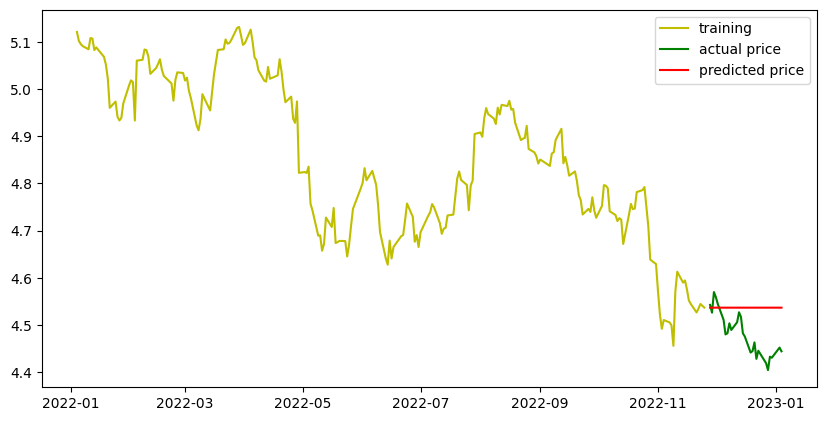

In [46]:
# Make as pandas series
fc3_series = pd.Series(fc3, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, c='y',label='training')
plt.plot(test_data, c='g', label='actual price')
plt.plot(fc3_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [47]:
print('(1,1,0)일 때')
mse = mean_squared_error(np.exp(test_data), np.exp(fc2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc3) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

(1,1,0)일 때
MSE:  40.4026434207292
MAE:  5.418588949851078
RMSE:  6.3563073730531
MAPE: 6.30%


#### MAPE 값은 15% 이하가 나왔지만, 그래프 상으로는 거의 예측하지 못했다. 

# 3. Alphabet
## STEP 1 : 시계열 데이터 준비

In [48]:
from google.colab import files
myfile = files.upload()

Saving GOOG.csv to GOOG.csv


In [49]:
#pd.read_csv로 csv파일 불러오기
data = pd.read_csv(io.BytesIO(myfile['GOOG.csv']), index_col='Date', parse_dates=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,145.550507,146.610001,143.816147,144.416504,144.416504,22928000
2022-01-05,144.181000,144.298004,137.523499,137.653503,137.653503,49642000
2022-01-06,137.497498,139.686005,136.763504,137.550995,137.550995,29050000
2022-01-07,137.904999,138.254745,135.789001,137.004501,137.004501,19408000
2022-01-10,135.098999,138.639999,133.140503,138.574005,138.574005,34096000


In [50]:
ts = data['Close']
ts.head()

Date
2022-01-04    144.416504
2022-01-05    137.653503
2022-01-06    137.550995
2022-01-07    137.004501
2022-01-10    138.574005
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

In [51]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

#### 결측치는 없다. 

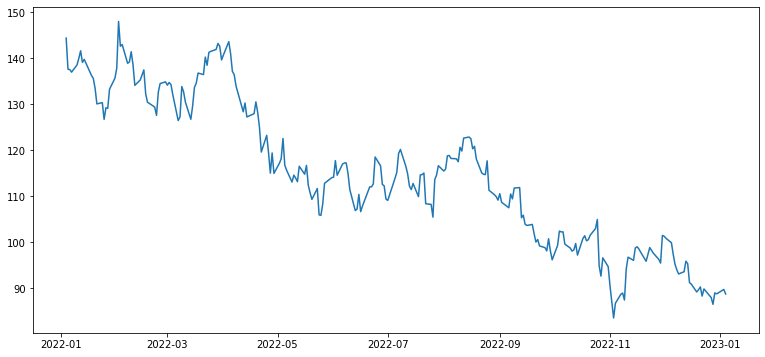

In [52]:
plt.plot(ts)

#### 또 폭락이다.